In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D, Dense,BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Wszystkie potrzebne importy | All necessary imports

In [2]:

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'train3')
test_dir = os.path.join(current_dir, 'test3')
image_count = len(glob.glob(data_dir + '/*/*.jpeg'))
print("Zestaw do trenowania")
print(image_count)
image_count = len(glob.glob(test_dir + '/*/*.jpeg'))
print("Zestaw do testowania")
print(image_count)

Zestaw do trenowania
2301
Zestaw do testowania
1025


Przygotowanie folderów ze zdjęciami | Preping directiories with photos

In [3]:
batch_size = 32
img_height = 224
img_width = 224
train_datagen = ImageDataGenerator(rescale = 1./255, 
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
train_ds = train_datagen.flow_from_directory(
  data_dir,
  subset="training",
  class_mode='categorical',
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)


Found 1841 images belonging to 10 classes.


Dane treningowe | Training data

In [5]:
val_ds = val_datagen.flow_from_directory(
  data_dir,
  class_mode='categorical',
  subset="validation",
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 460 images belonging to 10 classes.


Dane walidacyjne | Validation data

In [6]:
test_ds = train_datagen.flow_from_directory(
  test_dir,
  class_mode='categorical',
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 1025 images belonging to 10 classes.


Dane testowe | Test data

In [7]:
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

MobileNetV2_base.trainable = False
num_classes = len(train_ds.class_indices)

model = Sequential()
model.add(MobileNetV2_base)
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(220, activation='relu')) 
model.add(BatchNormalization())
model.add(Dense(60, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Obiekt modelu sekwencyjnego | Sequential Model Object

MobileNetV2\
Jest to wcześniej wytrenowany model konwolucyjnej sieci neuronowej, który został wytrenowany na zbiorze danych ImageNet.\
BatchNormalization()\
a warstwa normalizuje aktywacje poprzedniej warstwy w każdej partii danych, co przyspiesza trening i wprowadza pewną regularizację do modelu.\
Dropout(0.35)\
Ta warstwa losowo ustawia 35% jednostek wejściowych na 0 w każdej aktualizacji podczas treningu, co pomaga zapobiegać przeuczeniu (overfitting).\
Dense\
Warstwy gęsto połączone z funkcją aktywacji ReLU.\
Ostatnia warstwa gęsto połączona z funkcją aktywacji softmax.


In [8]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Kompilacja modelu | Model compilation

In [9]:
epochs=100
early_stopping = EarlyStopping(patience=20)
learn = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    steps_per_epoch=len(train_ds),
    callbacks=[early_stopping]
)
test_loss,test_accuracy = model.evaluate(test_ds)

Epoch 1/100


c:\Users\blaze\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 377ms/step - accuracy: 0.1482 - loss: 2.6725 - val_accuracy: 0.4217 - val_loss: 1.8016
Epoch 2/100


c:\Users\blaze\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4217 - val_loss: 1.8016
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.4263 - loss: 1.6970 - val_accuracy: 0.7109 - val_loss: 1.2713
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7109 - val_loss: 1.2713
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.6162 - loss: 1.2825 - val_accuracy: 0.8261 - val_loss: 0.9158
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8261 - val_loss: 0.9158
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 359ms/step - accuracy: 0.7375 - loss: 0.9649 - val_accuracy: 0.8652 - val_loss: 0.7024
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8652 - val_loss: 0.7024
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.7869 - los

Trenowanie modelu | Model training\
Testowanie na danych testowych | Testing using test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


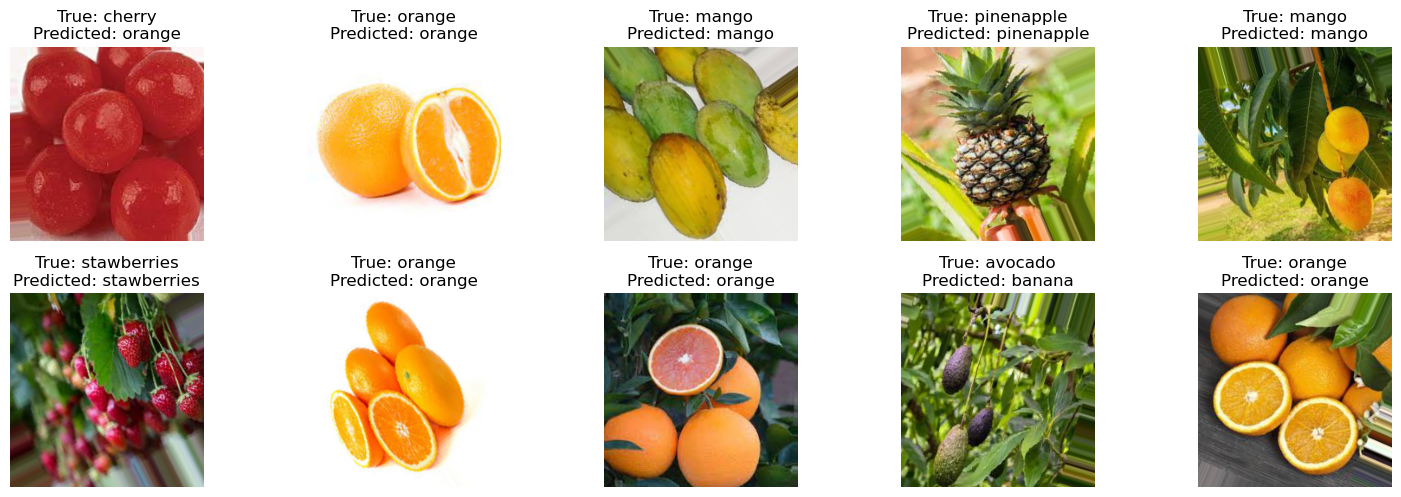

In [10]:
class_labels = list(test_ds.class_indices.keys())

num_images = 10
num_images_per_row = 5 
num_rows = 4

plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(test_ds)
    predictions = model.predict(image)
    
    for j in range(len(image)):
        if i * len(image) + j < num_images: 
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(label[j])]
            
            plt.subplot(num_rows, num_images_per_row, i * len(image) + j + 1)
            plt.imshow(image[j])
            plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
            plt.axis('off')

plt.tight_layout()
plt.show()

Przetestowanie modelu | Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

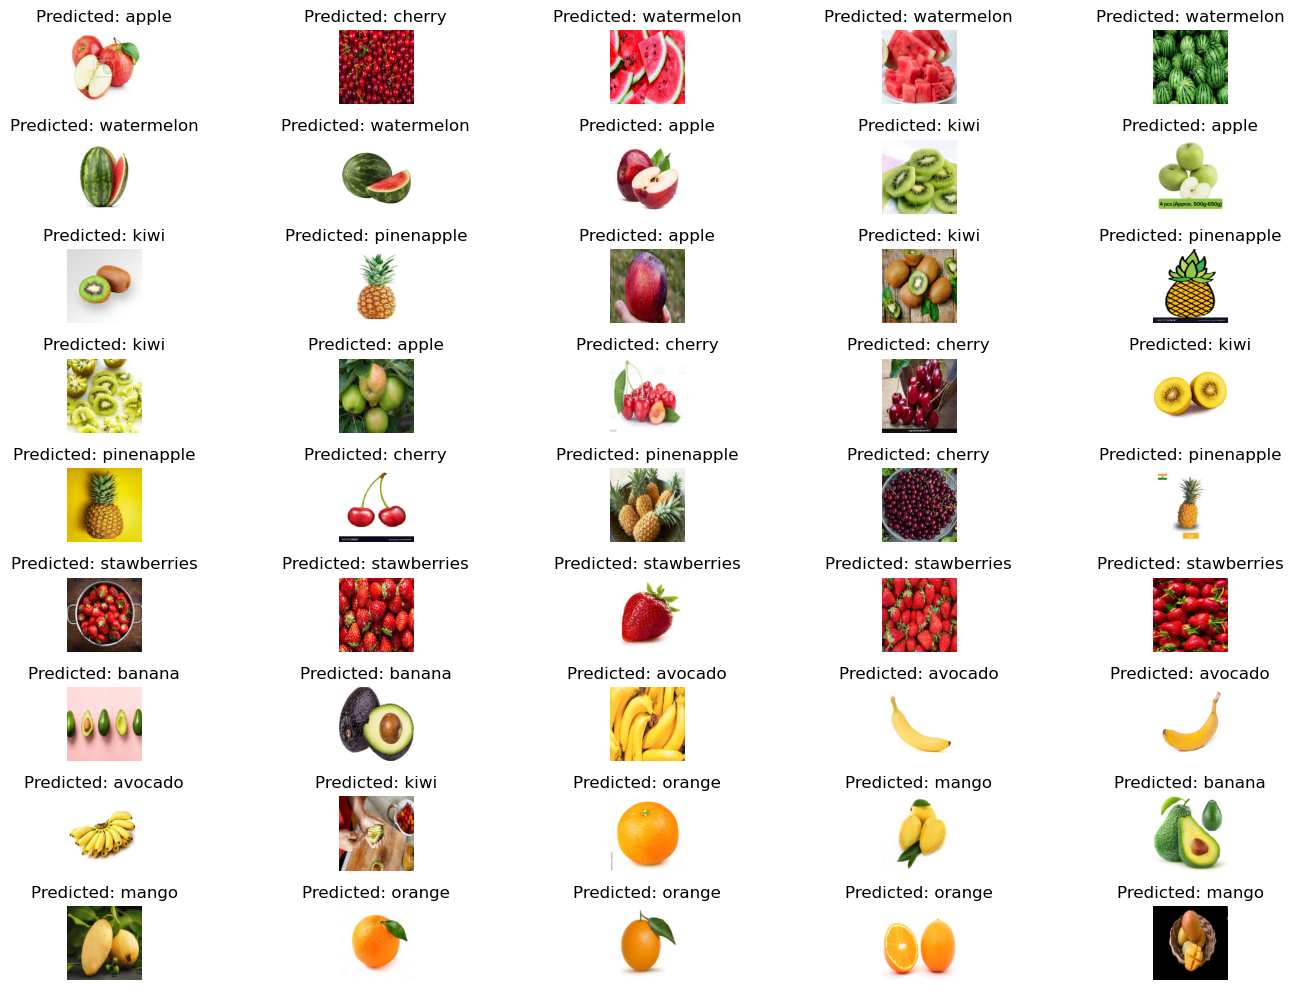

In [37]:
def load_and_preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image) / 255.0
    return image_array

pred_dir = os.path.join(current_dir, 'predict')
image_files = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir) if os.path.isfile(os.path.join(pred_dir, f))]
num_images = min(45, len(image_files))
plt.figure(figsize=(15, 10))
for i in range(num_images):
    image_path = image_files[i]
    image_array = load_and_preprocess_image(image_path, target_size=(img_height, img_width))
    image_batch = np.expand_dims(image_array, axis=0)
    predictions = model.predict(image_batch)
    predicted_class = class_labels[np.argmax(predictions[0])]
    plt.subplot(num_images // 5, 5, i + 1)
    plt.imshow(image_array)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Użycie modelu | Using the model

In [38]:
model.save('fruit_model2.keras')

Zapisywanie modelu | Saving model